# Diffuse

> Transforms an image based on a given prompt.  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| default_exp diffuse

In [3]:
#| export
import numpy as np
from PIL import Image
import cv2
from fastcore.basics import store_attr
from diffusers import AutoPipelineForImage2Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector
from mmm_st.config import Config


In [4]:
#| export
class BaseTransformer:
    def __init__(
            self,
            model_name=Config.MODEL_NAME,
            device='cuda',
        ):
        store_attr()
        
    def transform_image(self, image, prompt):
        raise NotImplementedError("This method should be overridden by subclasses.")
    
    def __call__(self, *args, **kwargs):
        return self.transform_image(*args, **kwargs)

In [5]:
#| export
class ImageTransformer(BaseTransformer):
    """
    A class to manage image transformation using the Hugging Face diffusers pipeline.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pipeline = self._initialize_pipeline()

    def _initialize_pipeline(self):
        """
        Initializes the img2img pipeline with model settings optimized for performance.
        """
        pipe = AutoPipelineForImage2Image.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            use_safetensors=True,
        ).to(self.device)
        pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
        pipe.enable_model_cpu_offload()
        return pipe

    def transform_image(self, image, prompt):
        """
        Transforms an image based on a given prompt using a pre-trained model.

        Args:
            image: A numpy array of the image to transform.
            prompt (str): The creative prompt to guide the image transformation.

        Returns:
            PIL.Image: The transformed image.
        """
        transformed_image = self.pipeline(prompt, image=image).images[0]
        return transformed_image

In [6]:
#| export
class EdgeImageTransformer(BaseTransformer):
    def __init__(
            self,
            *args, 
            canny_control_model=Config.CONTROL_NET_CANNY_MODEL,
            **kwargs,
        ):
        super().__init__(*args, **kwargs)
        self.canny_control_model = canny_control_model
        self.pipeline = self._initialize_pipeline()

    def _initialize_pipeline(self):
        controlnet = ControlNetModel.from_pretrained(self.canny_control_model, torch_dtype=torch.float16)
        pipe = StableDiffusionControlNetPipeline.from_pretrained(
            self.model_name,
            controlnet=controlnet,
            torch_dtype=torch.float16
        ).to(self.device)
        pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
        pipe.enable_model_cpu_offload()
        return pipe

    def transform_image(self, image, prompt, low_threshold=100, high_threshold=200):
        edge_image = cv2.Canny(image, low_threshold, high_threshold)
        edge_image = np.stack((edge_image, edge_image, edge_image), axis=-1)  # Convert to 3-channel image
        transformed_images = self.pipeline(
            prompt=[prompt],
            images=[Image.fromarray(edge_image)],
            num_inference_steps=20
        ).images
        return transformed_images[0]

In [7]:
#| export
class PoseImageTransformer(BaseTransformer):
    def __init__(
            self,
            *args, 
            pose_control_model=Config.CONTROL_NET_CANNY_MODEL,
            pose_det_model=Config.POSE_DET_MODEL,
            **kwargs,
        ):
        super().__init__(*args, **kwargs)
        self.pose_control_model = pose_control_model
        self.pose_det_model = pose_det_model
        self.pipeline = self._initialize_pipeline()
        self.pose_model = OpenposeDetector.from_pretrained(self.pose_det_model)

    def _initialize_pipeline(self):
        controlnet = ControlNetModel.from_pretrained(
            self.pose_control_model, torch_dtype=torch.float16
        )
        pipe = StableDiffusionControlNetPipeline.from_pretrained(
            self.model_name, controlnet=controlnet, torch_dtype=torch.float16
        ).to(self.device)
        pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
        pipe.enable_model_cpu_offload()
        return pipe

    def transform_image(self, image, prompt):
        pose_image = self.pose_model(image)
        transformed_images = self.pipeline(
            prompt=[prompt],
            images=[pose_image],
            num_inference_steps=20
        ).images
        return transformed_images[0]

In [8]:
#|export 
class CombinedImageTransformer(BaseTransformer):
    def __init__(
            self,
            *args, 
            canny_control_model=Config.CONTROL_NET_CANNY_MODEL,
            pose_control_model=Config.CONTROL_NET_CANNY_MODEL,
            pose_det_model=Config.POSE_DET_MODEL,
            **kwargs,
        ):
        super().__init__(*args, **kwargs)
        self.canny_control_model = canny_control_model
        self.pose_control_model = pose_control_model
        self.pose_det_model = pose_det_model
        self.pipeline = self._initialize_pipeline()
        self.pose_model = OpenposeDetector.from_pretrained(self.pose_det_model)

    def _initialize_pipeline(self):
        controlnet = [
            ControlNetModel.from_pretrained(self.pose_control_model, torch_dtype=torch.float16),
            ControlNetModel.from_pretrained(self.canny_control_model, torch_dtype=torch.float16),
        ]
        pipe = StableDiffusionControlNetPipeline.from_pretrained(
            self.model_name,
            controlnet=controlnet,
            torch_dtype=torch.float16,
            safety_checker="CompVis/stable-diffusion-safety-checker",
            tokenizer="gpt2",
            requires_safety_checker=False,
        ).to(self.device)
        pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
        pipe.enable_model_cpu_offload()
        return pipe

    def transform_image(self, image, prompt):
        """
        Transforms an image based on a given prompt using combined control nets for pose and edges.

        Args:
            image: A numpy array of the image to transform.
            prompt (str): The creative prompt to guide the image transformation.

        Returns:
            PIL.Image: The transformed image.
        """
        prepared_pose_image = self.prepare_pose_image(image)
        prepared_canny_image = self.prepare_canny_image(image)
        images = [prepared_pose_image, prepared_canny_image]
        negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
        controlnet_conditioning_scale = [1.0, 0.8]
        num_inference_steps = 20

        transformed_images = self.pipeline(
            prompt=prompt,
            images=images,
            num_inference_steps=num_inference_steps,
            generator=torch.Generator(device="cpu").manual_seed(1),
            negative_prompt=[negative_prompt],
            controlnet_conditioning_scale=controlnet_conditioning_scale
        ).images

        return transformed_images[0]

    def prepare_canny_image(self, image, low_threshold=100, high_threshold=200):
        canny_image = cv2.Canny(image, low_threshold, high_threshold)
        zero_start = canny_image.shape[1] // 4
        zero_end = zero_start + canny_image.shape[1] // 2
        canny_image[:, zero_start:zero_end] = 0
        canny_image = np.stack((canny_image, canny_image, canny_image), axis=-1)
        return Image.fromarray(canny_image)

    def prepare_pose_image(self, image):
        return self.pose_model(image)

In [9]:
#|export
def get_transformer(transformer_type):
    if transformer_type == "regular":
        return ImageTransformer()
    elif transformer_type == "canny":
        return EdgeImageTransformer()
    elif transformer_type == "pose":
        return PoseImageTransformer()
    elif transformer_type == "combined":
        return CombinedImageTransformer()
    else:
        raise ValueError("Unknown transformer type provided")


In [10]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers import UNet2DConditionModel, AutoencoderKL
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from transformers import AutoTokenizer, AutoFeatureExtractor, CLIPTextModel, CLIPVisionModel
from diffusers.utils import load_image
import numpy as np
from PIL import Image
import cv2


In [11]:
from huggingface_hub import notebook_login
notebook_login()

In [12]:
tokenizer = AutoTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")

In [13]:

# Load necessary components directly from the runwayml model repository
feature_extractor = AutoFeatureExtractor.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="feature_extractor")


/Users/cck/mambaforge/envs/nb-edu/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [14]:

text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder")


In [15]:

# image_encoder = CLIPVisionModel.from_pretrained("runwayml/stable-diffusion-v1-5")


In [16]:

safety_checker = None #StableDiffusionSafetyChecker.from_pretrained("runwayml/stable-diffusion-v1-5")


In [17]:

scheduler = UniPCMultistepScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")


In [18]:

# Load UNet and VAE directly from the repository
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")


In [19]:

# Load ControlNet models for specific conditioning
pose_control_model = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
canny_control_model = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)


In [29]:

# # Initialize the Stable Diffusion ControlNet pipeline
# pipe = StableDiffusionControlNetPipeline(
#     tokenizer=tokenizer,
#     text_encoder=text_encoder,
#     unet=unet,
#     vae=vae,
#     scheduler=scheduler,
#     feature_extractor=feature_extractor,
#     safety_checker=None,
#     controlnet=[pose_control_model, canny_control_model],
#     requires_safety_checker=False,
# ).to("cpu")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=[pose_control_model, canny_control_model],
    torch_dtype=torch.float16,

)

# Enable model optimizations
pipe.enable_model_cpu_offload()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

AssertionError: Torch not compiled with CUDA enabled

In [21]:

# Load images
pose_image_path = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
canny_image_path = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/landscape.png"

pose_image = load_image(pose_image_path)
canny_image = load_image(canny_image_path)


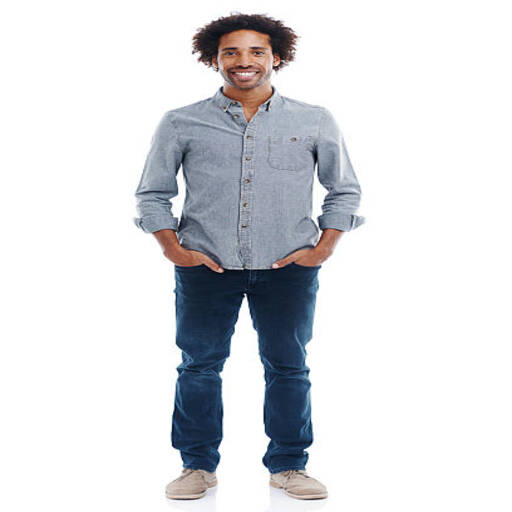

In [22]:
pose_image

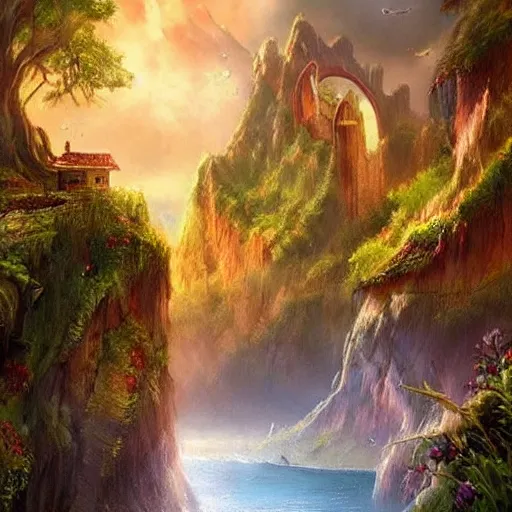

In [23]:
canny_image

In [24]:
from controlnet_aux import OpenposeDetector

pose_model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")


In [25]:

# Convert images to numpy arrays
pose_image = np.array(pose_image)
canny_image = np.array(canny_image)

# Prepare pose image using OpenPose model (Placeholder for real function)
def prepare_pose_image(image):
    # Assuming a real OpenPose model preprocessing here
    return pose_model(image)

# Prepare canny image
def prepare_canny_image(image, low_threshold=100, high_threshold=200):
    canny_image = cv2.Canny(image, low_threshold, high_threshold)
    canny_image = np.stack((canny_image, canny_image, canny_image), axis=-1)
    return Image.fromarray(canny_image)

# Prepare images
prepared_pose_image = prepare_pose_image(pose_image)
prepared_canny_image = prepare_canny_image(canny_image)


In [26]:

# Transform the image
prompt = "a giant standing in a fantasy landscape, best quality"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
images = [prepared_pose_image, prepared_canny_image]

result_image = pipe(
    prompt=prompt,
    image=images,
    num_inference_steps=20,
    generator=torch.Generator(device="cpu").manual_seed(1),
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.0, 0.8]
).images[0]

# Display or save the result
result_image.save("./multi_controlnet_output.png")


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()